In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil
import math

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Access pickle file
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Get model output from pickle file
s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [68]:
# Load specific zdata you want to analyze (make sure the number of subtypes and input features are correct)
zdata = pandas.read_csv('zdata- subtype 1 A.csv')

#Housekeeping
zdata = zdata.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)
zdata

,RID,Diagnosis,AGE,ADAS11_bl,Average_hippo,Average_meta_tau,ctx_entorhinal_tau,ctx_inferiorparietal_tau,ctx_inferiortemporal_tau,ctx_parahippocampal_tau,...,Average_superiorfrontal_vol,Average_anteriorcingulate_vol,Average_posteriorcingulate_vol,Average_precuneus_vol,Average_inferiorparietal_vol,Average_inferiortemporal_vol,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,21,CN,72.6,-0.172429,0.062109,0.134515,-0.011721,-0.175590,0.356465,-0.215946,...,0.449522,0.301755,0.532955,0.757263,-0.239702,1.704690,0.0,1.0,3.0,0.169613
1,31,CN,77.7,-1.735559,2.046008,-0.392692,0.623041,-0.477772,-0.668344,-0.214256,...,0.819599,0.170225,0.503228,-0.052603,0.279301,1.286340,0.0,1.0,0.0,0.168466
2,56,MCI,69.6,-1.319766,0.710701,0.456155,1.153732,0.418942,0.147350,0.695881,...,0.502718,2.723248,0.207082,-0.088145,0.967623,1.773868,0.0,1.0,0.0,0.160360
3,59,MCI,70.9,-0.069262,0.581602,0.544075,0.635106,0.399789,0.297354,0.546652,...,1.084545,0.817633,0.672696,0.396530,1.746611,1.869215,0.0,1.0,5.0,0.203203
4,69,MCI,72.9,0.346530,0.370436,1.093217,0.857338,0.732524,0.930174,1.370171,...,-0.376692,-0.057383,0.429549,-0.127077,0.361946,0.004851,0.0,1.0,5.0,0.166663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,6704,MCI,65.3,3.160164,0.470892,-0.188450,-0.323373,0.191931,-0.064490,-0.385318,...,1.752011,1.306636,0.455020,0.965912,1.024877,1.925646,0.0,1.0,3.0,0.210169
646,6705,MCI,74.9,0.971782,2.098817,1.965910,2.678315,1.139518,1.376567,1.959302,...,-0.001617,1.134429,0.922593,-0.098058,0.080927,-0.253239,0.0,1.0,9.0,0.267007
647,6713,CN,71.1,0.971782,0.521152,-0.249232,-0.260623,0.234837,-0.127469,-0.497668,...,-0.221338,0.301398,-1.040388,-0.699135,-0.754194,-0.464371,0.0,1.0,1.0,0.208320
648,6721,Dementia,77.9,3.785416,2.874163,-0.762779,-0.695716,-1.116853,-0.748597,-0.866402,...,0.185680,1.569582,-0.350836,0.463439,-0.699300,-0.347036,0.0,1.0,4.0,0.230618


In [54]:
# SPECIFY THE NUMBER OF SUBTYPES
nsubtypes = 1

In [55]:
if nsubtypes > 1:
    print(zdata.ml_subtype.value_counts())
    
print(zdata.ml_stage.value_counts())

ml_stage
0.0     293
1.0      67
2.0      39
6.0      37
3.0      33
5.0      30
4.0      28
7.0      23
14.0     17
8.0      16
12.0     14
15.0     13
9.0      12
13.0     12
10.0     11
11.0      5
Name: count, dtype: int64


## Generate Stage Histogram

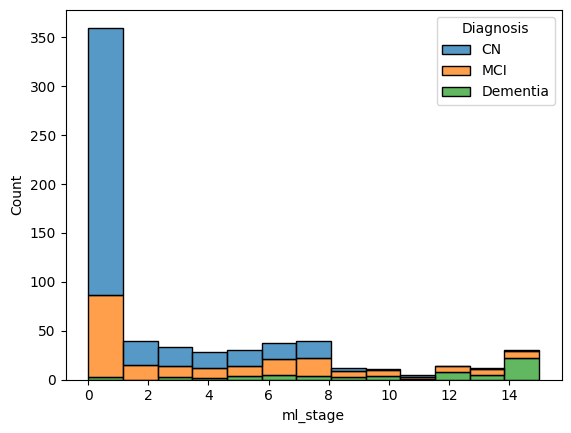

In [56]:
# Use clincial diagnostic categories as a rough way to assess the success of the model's stage assignments

if nsubtypes < 2:  # If only one subtype
    sns.histplot(data=zdata, x='ml_stage', hue='Diagnosis', multiple='stack')
    plt.show()
else:  # If multiple subtypes
    sns.displot(data=zdata, x='ml_stage', hue='Diagnosis', col='ml_subtype', kind='hist', multiple='stack')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


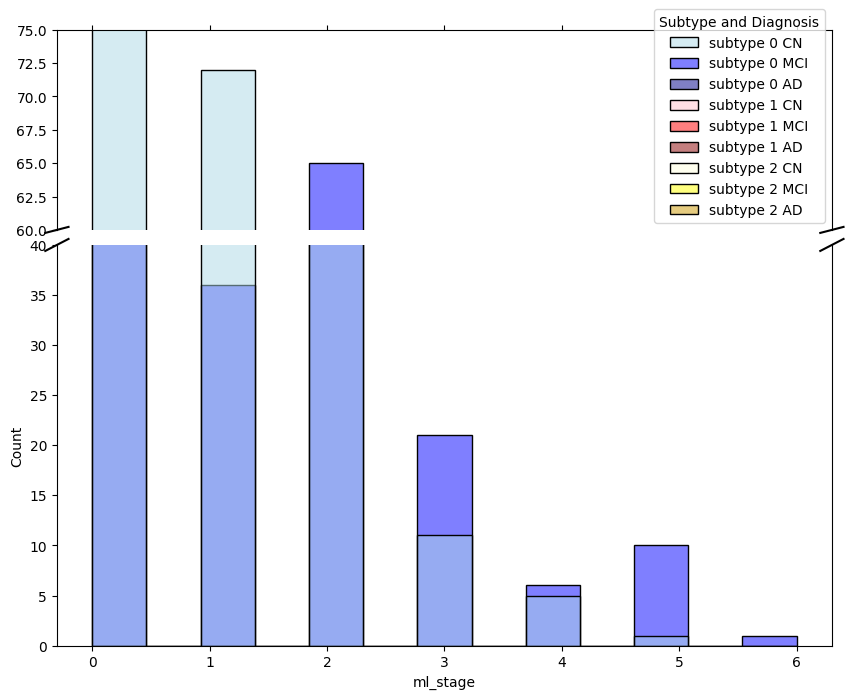

In [8]:
# Joint plot

zdata['ml_subtype'] = zdata['ml_subtype'].astype(int)
zdata['Subtype and Diagnosis'] = 'subtype ' + zdata['ml_subtype'].astype(str) + ' ' + zdata['Diagnosis'].astype(str)

# Define your palette
palette = {
    "subtype 0 CN": "lightblue", "subtype 0 MCI": "blue", "subtype 0 AD": "darkblue",  # Subtype 0
    "subtype 1 CN": "pink", "subtype 1 MCI": "red", "subtype 1 AD": "#8B0000",  # Subtype 1
    "subtype 2 CN": "lightyellow", "subtype 2 MCI": "#FFFF00", "subtype 2 AD": "#CC9900"  # Subtype 2
}

hue_order = [
    "subtype 0 CN", "subtype 0 MCI", "subtype 0 AD",
    "subtype 1 CN", "subtype 1 MCI", "subtype 1 AD",
    "subtype 2 CN", "subtype 2 MCI", "subtype 2 AD"
]

# Create figure and subplots for broken y-axis effect
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(10, 8),
                                        gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.05})

# Top histogram (for larger values or to hide)
sns.histplot(data=zdata, x="ml_stage", hue="Subtype and Diagnosis", palette=palette, hue_order=hue_order, ax=ax_top)
ax_top.set_ylim(60, 75)  # Adjust based on your data
ax_top.spines['bottom'].set_visible(False)
ax_top.xaxis.tick_top()
ax_top.tick_params(labeltop=False)  # Hide top tick labels

# Bottom histogram (for the rest of the data)
sns.histplot(data=zdata, x="ml_stage", hue="Subtype and Diagnosis", palette=palette, hue_order=hue_order, ax=ax_bottom)
ax_bottom.set_ylim(0, 40)  # Adjust based on your data
ax_bottom.spines['top'].set_visible(False)

# Add diagonal lines to indicate the break in the y-axis
d = .015  # Size of diagonal lines
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax_bottom.transAxes)  # Switch to bottom axes
ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Formatting
ax_top.set_ylabel('')  # This sets the y-axis label to an empty string for the top plot
ax_bottom.legend().remove()

plt.show()

# Trajectory plots for each biomarker

In [69]:
# store our biomarker labels as a variable
biomarkers = zdata.columns[[3,4,6,7,8,9,10,11]]
print(biomarkers)

Index(['ADAS11_bl', 'Average_hippo', 'ctx_entorhinal_tau',
       'ctx_inferiorparietal_tau', 'ctx_inferiortemporal_tau',
       'ctx_parahippocampal_tau', 'Hippocampus_tau', 'Amygdala_tau'],
      dtype='object')


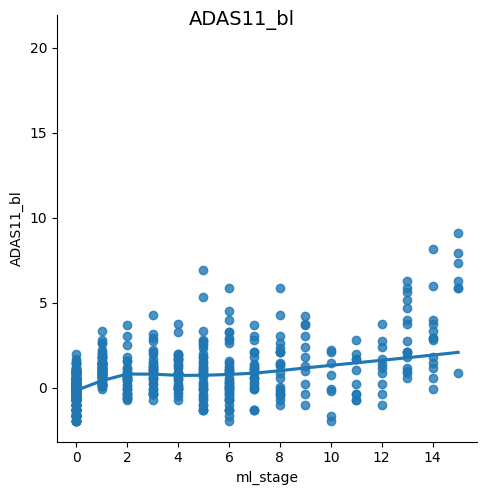

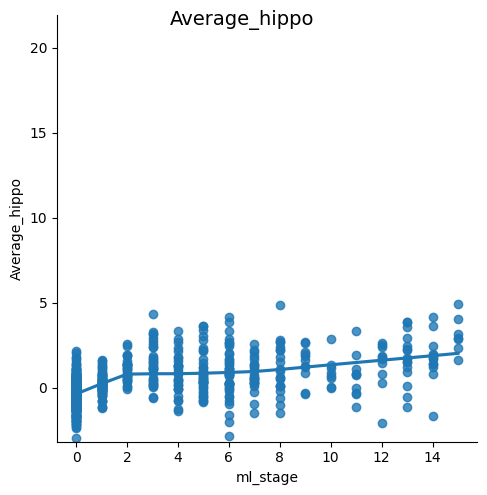

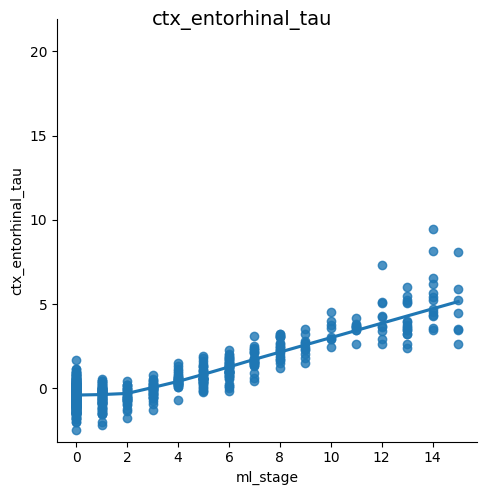

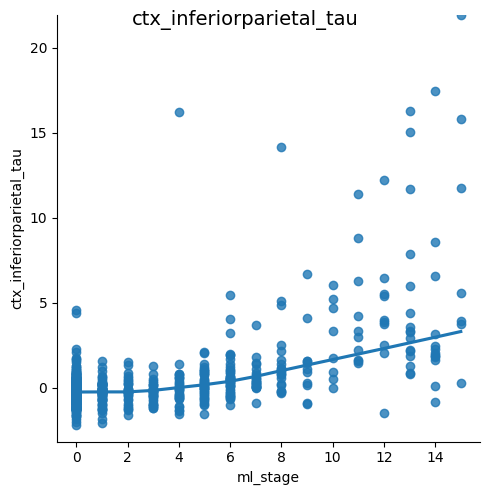

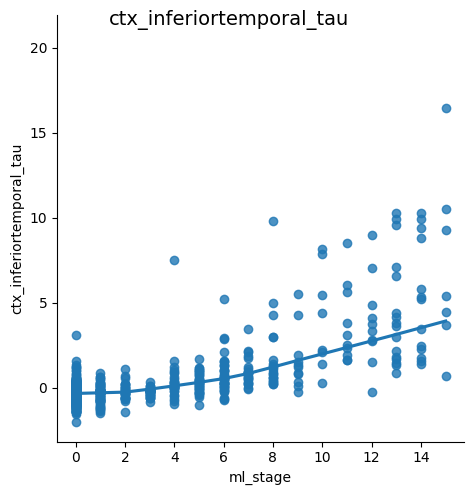

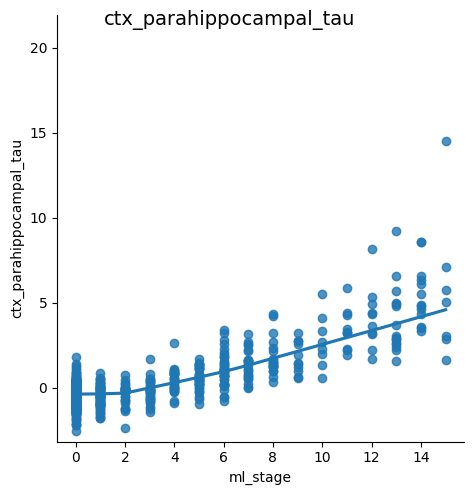

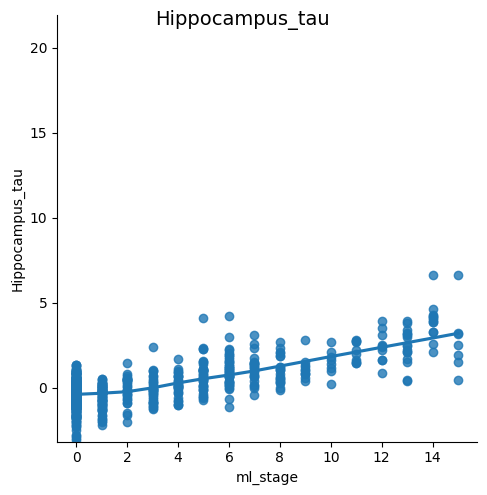

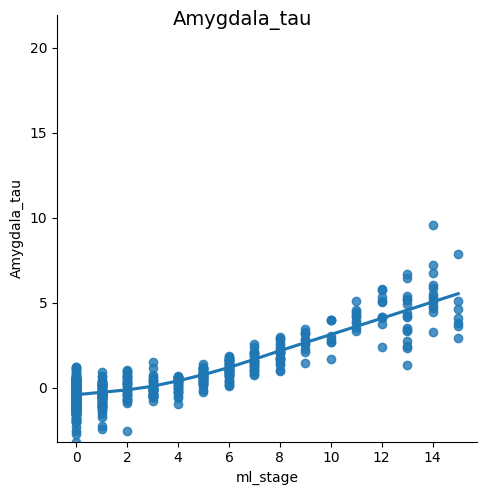

In [70]:
y_min = zdata[biomarkers].min().min()  # Global minimum across all biomarkers
y_max = zdata[biomarkers].max().max()  # Global maximum across all biomarkers

if nsubtypes < 2: # If only one subtype
    
    for biomarker in biomarkers:
    
        # plot relationship between each biomarker and stage for each subject
        sns.lmplot(x='ml_stage',y=biomarker, data = zdata,lowess=True) 

        # Add a title to the plot
        plt.gcf().suptitle(biomarker, fontsize=14) 

        # Set the same y-axis range for all plots
        plt.ylim(y_min, y_max)

        plt.show()
    
else: # If multiple subtypes

    for biomarker in biomarkers:
        # Plot relationship between each biomarker and stage for all subtypes together
        sns.lmplot(x='ml_stage', y=biomarker, hue='ml_subtype', data=zdata, lowess=True, aspect=1.5)

        # Add a title to the plot
        plt.title(f'{biomarker} Across Subtypes', fontsize=14)

        # Set the same y-axis range for all plots
        plt.ylim(y_min, y_max)

        plt.show()

# Calculate y_k at each stage for a biomarker
Can use this code for any biomarker, including tau regional values and functional metrics. 

In [71]:
# Load data for biomarker of interest 
data = pandas.read_csv('Cog_Tau_V1.csv')
#data = pandas.read_csv('FinalEBM_input.csv')

#Housekeeping
data = data.drop(['Unnamed: 0'], axis=1)
data = data.rename(columns ={'merge_RID' : 'RID'})

# Delete RIDs with NaN values in any column (only run for 'Cog_Tau_V1.csv') and redundant RIDS
indices_to_drop = [97,105, 238, 250, 388, 400, 439, 454, 734, 778]
data = data.drop(indices_to_drop, axis=0)
data = data.drop_duplicates(subset='RID', keep='first')

# Delete redundant RIDs (when working with non-longitudinal data)
# #data = data.drop_duplicates(subset='RID', keep='first')

# Find the average of the right and left cerebellum 
data['Average_Cerebellum'] = (data['Left-Cerebellum-Cortex']+ data['Right-Cerebellum-Cortex'])/2

# Divide each regional tau value by the average of R and L cerebellum tau and subtract 1
data.iloc[:, 6:] = data.iloc[:, 6:].div(data['Average_Cerebellum'], axis=0) - 1

data = data.drop('Average_Cerebellum', axis=1)

# extract data for control subjects
data_control = data[data['merge_DX'] == 'CN']

# z-score
for col in data.columns[7:]:  
    
    # compute the mean and standard deviation of the control population
    mean_control = data_control[[col]].mean()
    std_control = data_control[[col]].std()

    # z-score the data
    data[[col]] = (data[[col]]-mean_control)/std_control

#If multiple subtypes
if nsubtypes > 1:

    # Create dictionaries of zdata, RIDS, data, and indices for each subtype
    zdata_dicts = {}
    RIDS_dicts = {}
    data_dicts = {}
    indices_dicts = {}

    # Fill in dictionaries for each subtype
    for subtype in range(1,nsubtypes + 1):

        key = subtype
        zdata_dicts[key] = zdata[zdata['ml_subtype'] == subtype]
    
        key_rids = subtype
        RIDS_dicts[key_rids] = zdata_dicts[key]['RID']
    
        key_data = subtype
        data_dicts[key_data] = data[data['RID'].isin(RIDS_dicts[key_rids])]
    
        key_indices = subtype
        indices_dicts[key_indices] = zdata[zdata['RID'].isin(RIDS_dicts[key_rids])].index

In [77]:
# Create a data frame for the stage probability distributions for each subject from pickle file
prob_stage = pandas.DataFrame(pk['prob_stage'])

# Define the number of stages 
stage_count = prob_stage.shape[1]

# Define biomarker of interest
biomarker_of_interest = 'Right-Amygdala' # INPUT BIOMARKER OF INTEREST HERE exactly as it appears in column title

if nsubtypes > 1:

    prob_stage_dicts = {}
    biomarker_values_dicts = {}
    
    for subtype in range(1,nsubtypes + 1):

        prob_stage_dicts[subtype] = prob_stage.loc[indices_dicts[subtype]]
        
        # Extract the biomarker data for the current subtype
        biomarker_data = data_dicts[subtype][biomarker_of_interest]

        #Initialize list of y(k) values for each stage k within biomarkers_values dictionary 
        biomarker_values_dicts[subtype] = []

        for k in range(int(stage_count)): # For each stage k
            sum = 0 # Define a variable for sum of all subjects i (numerator)

            for i in range(len(biomarker_data)): # For each subject i 
        
                prob = prob_stage_dicts[subtype].iloc[i, k] # Define the probability that subject i is in stage k
                value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                product = prob * value # Multiply 
                sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

            column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

            final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
            biomarker_values_dicts[subtype].append(final_value) # Save sum to biomarker_values list

        # Print list of y(k) values (each value in list corresponds to a stage k)
        print('Subtype ' + str(subtype) + ' biomarker values: ' + str(biomarker_values_dicts[subtype]))
        
else:
    
    # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
    biomarker_data = data[biomarker_of_interest]

    #Initialize list of y(k) values for each stage k
    biomarker_values = []
    #Initialize list of the variance for each stage k
    variance_values = []

    for k in range(int(stage_count)): # For each stage k
        total = 0 # Define a variable for sum of all subjects i (numerator)

        for i in range(len(biomarker_data)): # For each subject i 
            prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k 
            value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
            product = prob * value # Multiply 
            total = total + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

        column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 
        mean = total / column_sum # Normalize with sum of probabilities for each subject in stage k
        biomarker_values.append(mean) # Save mean to biomarker_values list

        variance = 0 # Define variance for stage k
        
        for i in range(len(biomarker_data)): # For each subject i 
            prob = prob_stage.iloc[i, k] 
            value = biomarker_data.iloc[i] 
            variance_individual = prob * (value - mean) ** 2
            variance = variance + variance_individual 

        variance = variance / len(biomarker_data) # Normalize
        variance = math.sqrt(variance) # Take the square root
        
        variance_values.append(variance) # Save variance to list for stage k

    # Print list of y(k) values (each value in list corresponds to a stage k)
    print('Biomarker values: ' + str(biomarker_values))
    print('Variance values: ' + str(variance_values))

Biomarker values: [0.38769756483659734, 0.4044789343026676, 0.4276445607637633, 0.4418888561577595, 0.45311917588745604, 0.4800002727753497, 0.5270593377964947, 0.5860809593200301, 0.7375239515165546, 0.9408328140914244, 1.1322954673758137, 1.2130784874956135, 1.0314952305191605, 0.8486616011196304, 1.1671212891581901, 2.7925873640483183]
Variance values: [0.6826921341005218, 0.6164056311212491, 0.570474063438644, 0.5194070049549258, 0.46128334755006944, 0.4037303196681352, 0.34334668164367393, 0.2905273700729692, 0.2703542192098109, 0.2711716819315109, 0.2820198543591948, 0.29767919721380665, 0.29469893806999725, 0.3001950947610358, 0.38040943905377844, 0.384332036120973]


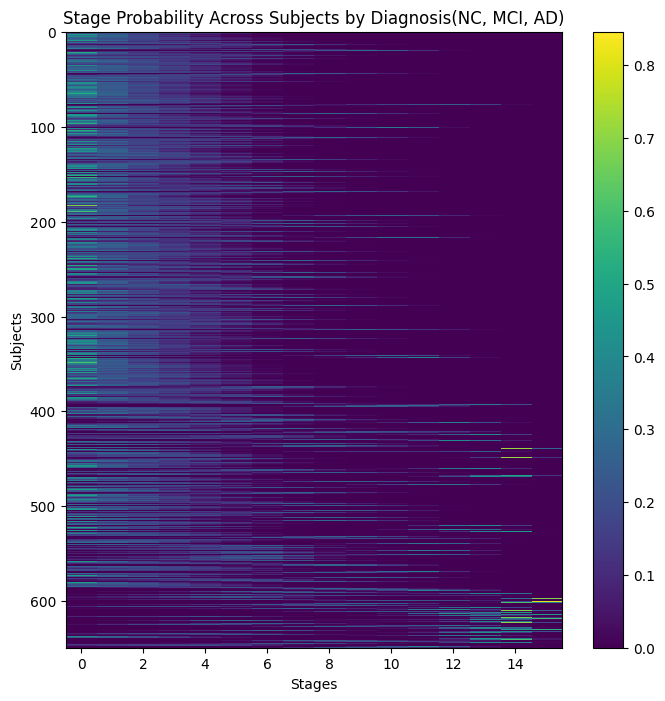

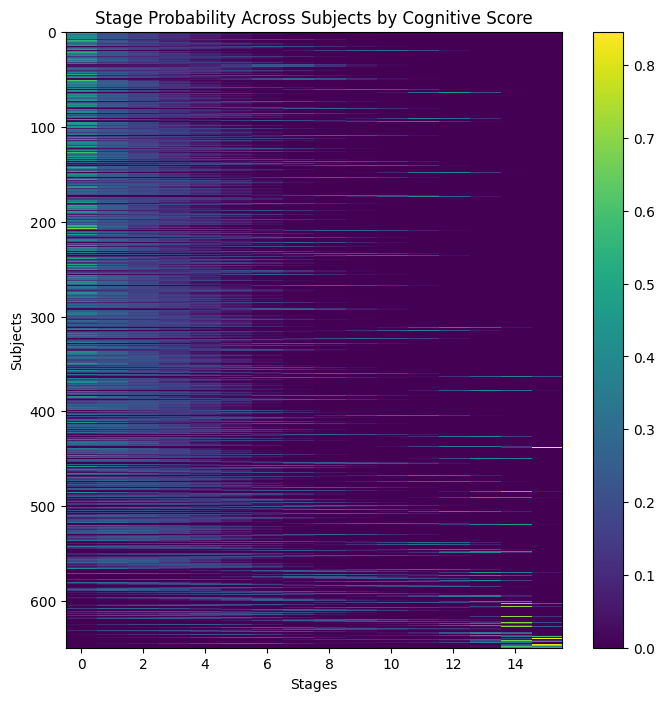

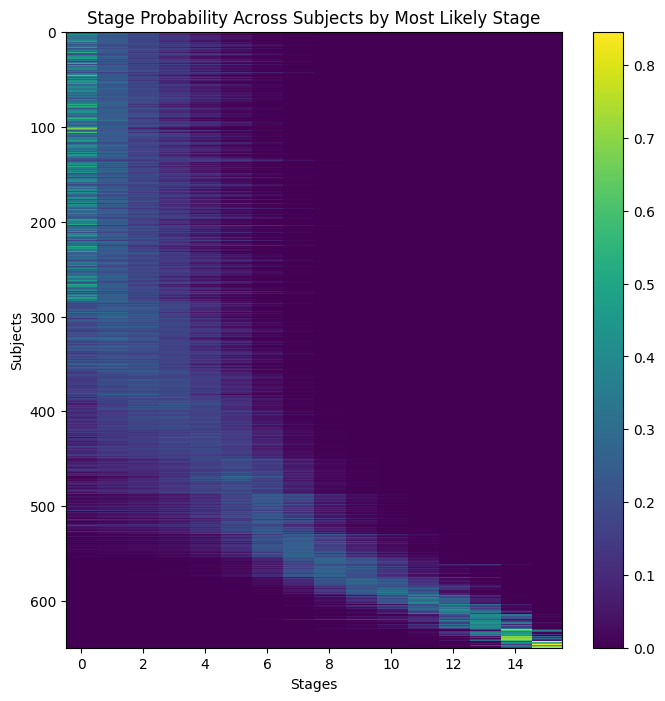

In [73]:
# Plot probability stage matrix

# Add diagnosis, cognitive score, and ml_stage to data frame
prob_stage_plot = pandas.merge(zdata,prob_stage,left_index=True, right_index=True)
prob_stage_plot = prob_stage_plot.iloc[:,[1, 3, 22] + list(range(24, prob_stage_plot.shape[1]))]

# Change diagnosis to numerical values
mapping = {'CN': 0, 'MCI': 1, 'Dementia': 2}
prob_stage_plot['Diagnosis'] = prob_stage_plot['Diagnosis'].map(mapping)

# In order of diagnosis...
by_diagnosis = prob_stage_plot.sort_values(by='Diagnosis')
by_diagnosis = by_diagnosis.iloc[:,3:]
plt.figure(figsize=(8, 8))  # Set the figure size to be square
plt.imshow(by_diagnosis, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Stage Probability Across Subjects by Diagnosis(NC, MCI, AD)')
plt.xlabel('Stages')  # Assume stages are along the x-axis
plt.ylabel('Subjects')  # Assume subjects are along the y-axis
plt.show()

# In order of cognitive score...
by_cog = prob_stage_plot.sort_values(by='ADAS11_bl')
by_cog = by_cog.iloc[:,3:]
plt.figure(figsize=(8, 8))  # Set the figure size to be square
plt.imshow(by_cog, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Stage Probability Across Subjects by Cognitive Score')
plt.xlabel('Stages')  # Assume stages are along the x-axis
plt.ylabel('Subjects')  # Assume subjects are along the y-axis
plt.show()

# In order of ml_stage
by_stage = prob_stage_plot.sort_values(by='ml_stage')
by_stage = by_stage.iloc[:,3:]
plt.figure(figsize=(8, 8))  # Set the figure size to be square
plt.imshow(by_stage, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Stage Probability Across Subjects by Most Likely Stage')
plt.xlabel('Stages')  # Assume stages are along the x-axis
plt.ylabel('Subjects')  # Assume subjects are along the y-axis
plt.show()

# Gaussian Interpolation 
Create and plot a continuous time series from discrete y_k values for biomarker of interest

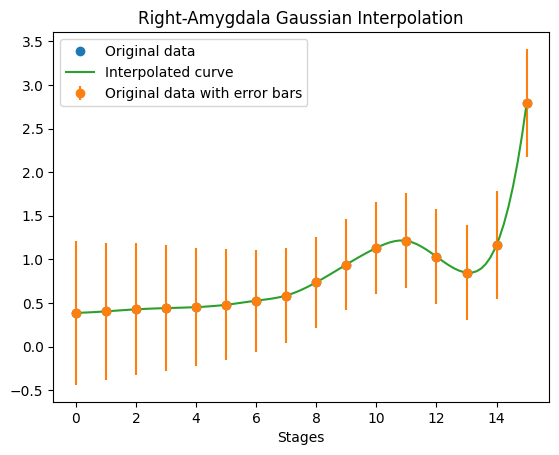

In [78]:
# With scipy.interpolate.interp1d

if nsubtypes > 1:

     for subtype in range(1,nsubtypes + 1):

        x = np.linspace(0, stage_count - 1,stage_count) 
        y = biomarker_values_dicts[subtype]

        # Perform interpolation 
        f = interp1d(x, y, kind='cubic')

        # New x values for which we want to interpolate
        xnew = np.linspace(0,stage_count - 1,100) 

        # Interpolate y values for the new x values
        ynew = f(xnew)

        # Plotting
        plt.plot(x, y, 'o', label='Original data')
        plt.plot(xnew, ynew, '-', label='Interpolated curve')
        plt.legend()
        plt.xlabel('Stages')
        plt.title('Subtype ' + str(subtype) + ' ' + biomarker_of_interest + ' Gaussian Interpolation')
        plt.show()

else:

    x = np.linspace(0, stage_count - 1,stage_count) 
    y = biomarker_values 
    variance = variance_values

    # Perform interpolation 
    f = interp1d(x, y, kind='cubic')

    # New x values for which we want to interpolate
    xnew = np.linspace(0,stage_count - 1,100) 

    # Interpolate y values for the new x values
    ynew = f(xnew)

    # Plotting
    plt.plot(x, y, 'o', label='Original data')
    plt.errorbar(x, y, yerr=np.sqrt(variance), fmt='o', label='Original data with error bars')

    plt.plot(xnew, ynew, '-', label='Interpolated curve')
    plt.legend()
    plt.xlabel('Stages')
    plt.title(biomarker_of_interest + ' Gaussian Interpolation')
    plt.show()

# Calculate a continous time series for a biomarker in every brain region
Perform the above operations for every brain region (currently looking at tau)

In [79]:
# Now let's calculate an interpolation for tau in every region --> this will become T(t) in Aim 2 or be ground truth for fitting Nexis

column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

if nsubtypes > 1:

    tau_array_dicts = {}
    tau_df_dicts = {}

    for subtype in range(1,nsubtypes + 1):

        tau_array_dicts[subtype] = None
         
        for region in data_dicts[subtype].columns[6:]: # Loop through tau in every region 

            # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
            biomarker_of_interest = region  
            
            # Extract the biomarker data for the current subtype
            biomarker_data = data_dicts[subtype][biomarker_of_interest]

            #Initialize list of y(k) values for each stage k within biomarkers_values dictionary 
            biomarker_values_dicts[subtype] = []

            for k in range(int(stage_count)): # For each stage k
                sum = 0 # Define a variable for sum of all subjects i (numerator)

                for i in range(len(biomarker_data)): # For each subject i 
        
                    prob = prob_stage_dicts[subtype].iloc[i, k] # Define the probability that subject i is in stage k
                    value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                    product = prob * value # Multiply 
                    sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

                column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

                final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
                biomarker_values_dicts[subtype].append(final_value) # Save sum to biomarker_values list

            x = np.linspace(0, stage_count - 1,stage_count) 
            y = biomarker_values_dicts[subtype]

            # Perform interpolation 
            f = interp1d(x, y, kind='cubic')

            # New x values for which we want to interpolate
            xnew = np.linspace(0,stage_count - 1,100) 

            # Interpolate y values for the new x values
            ynew = f(xnew)

            if tau_array_dicts[subtype] is None:
                tau_array_dicts[subtype] = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
            else:
                tau_array_dicts[subtype] = np.vstack((tau_array_dicts[subtype], ynew))
        
        print('Subtype ' + str(subtype) + ' regional tau: ' + str(tau_array_dicts[subtype]))

        # Convert tau array to labeled data frame and save to csv
        transpose_array = tau_array_dicts[subtype].T

        tau_df_dicts[subtype] = pandas.DataFrame(data=transpose_array, columns = column_labels)

else: 

    # Define an array for tau interpolations in every brain region
    tau_array = None
    
    for region in data.columns[6:]: # Loop through tau in every region 
    
        # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
        biomarker_of_interest = region  
        biomarker_data = data[biomarker_of_interest] 

        # Initialize list of y(k) values for each stage k
        biomarker_values = []
    
        for k in range(int(stage_count)): # For each stage k
            sum = 0 # Define a variable for sum of all subjects i (numerator)
    
            for i in range(len(zdata)): # For each subject i 
        
                prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k 
                value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                product = prob * value # Multiply 
                sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

            column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

            final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
            biomarker_values.append(final_value) # Save sum to biomarker_values list

    
        # Perform Gaussian interpolation with scipy.interpolate.interp1d

        x = np.linspace(0, stage_count - 1,stage_count) 
        y = biomarker_values

        # Perform interpolation 
        f = interp1d(x, y, kind='cubic')

        # New x values for which we want to interpolate
        xnew = np.linspace(0,stage_count - 1,100) 

        # Interpolate y values for the new x values
        ynew = f(xnew)

        if tau_array is None:
            tau_array = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
        else:
            tau_array = np.vstack((tau_array, ynew))
        
    print('Regional tau: ' + str(tau_array))

    # Convert tau array to labeled data frame and save to csv
    transpose_array = tau_array.T

    column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

    tau_df = pandas.DataFrame(data=transpose_array, columns = column_labels)
        

Regional tau: [[ 0.23052715  0.23041254  0.23029763 ...  0.52733529  0.58270482
   0.64657596]
 [ 0.03665022  0.03813177  0.03953234 ...  2.12210308  2.65863262
   3.28073283]
 [ 0.35738476  0.35556678  0.35375974 ...  3.39219375  4.01237122
   4.71925722]
 ...
 [ 0.38769756  0.38903642  0.39091204 ...  2.10956706  2.42752598
   2.79258736]
 [ 0.15542972  0.15343432  0.15222003 ...  1.45761597  1.68911648
   1.95199762]
 [-0.02994543 -0.03138113 -0.0325872  ...  0.60326869  0.70175183
   0.8156078 ]]


In [80]:
# Exclude striatal regions

# List of striatal regions to exclude from further analysis CAN EDIT THIS
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Delete striatal regions in tau_df
tau_df_excluded = tau_df.drop(columns=regions_to_exclude)
tau_array_excluded = tau_df_excluded.to_numpy()
tau_array_excluded = tau_array_excluded.T


In [81]:
# Save data frame to csv

if nsubtypes > 1:

    for subtype in range(1,nsubtypes + 1):
    
        tau_df_dicts[subtype].to_csv(f'Regional tau time series subtype {subtype} - regional tau (test).csv') # EDIT CSV NAME HERE

else:
    tau_df.to_csv('Regional tau time series - 1 subtype, stage 3).csv') # EDIT CSV NAME HERE



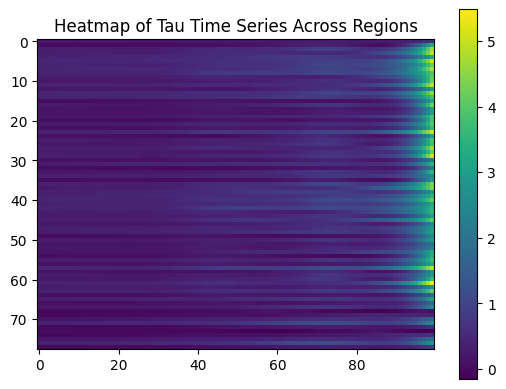

In [81]:
# Generate heatmap

if nsubtypes > 1:

    for subtype in range(1,nsubtypes + 1):

        plt.imshow(tau_array_dicts[subtype], cmap='viridis', interpolation='none')
        plt.colorbar()  # Add a color bar to map colors to values
        plt.title('Heatmap of Tau Time Series- Subtype ' + str(subtype))
        plt.show()

else:
    
    plt.imshow(tau_array_excluded, cmap='viridis', interpolation='none')
    plt.colorbar()  # Add a color bar to map colors to values
    plt.title('Heatmap of Tau Time Series Across Regions')
    plt.show()

In [119]:
# Preparing data frame for Nexis on individual subjects

stage_data = pandas.read_csv('zdata- 1 subtype final.csv')
stage_data = stage_data[['RID', 'Diagnosis', 'ml_stage']]

# Load data for biomarker of interest 
tau_data = pandas.read_csv('Cog_Tau_V1.csv')

#Housekeeping
tau_data = tau_data.drop(['Unnamed: 0'], axis=1)
tau_data = tau_data.rename(columns ={'merge_RID' : 'RID'})

# Delete RIDs with NaN values in any column (only run for 'Cog_Tau_V1.csv') and redundant RIDS if cross-sectional 
indices_to_drop = [97,105, 238, 250, 388, 400, 439, 454, 734, 778]
tau_data = tau_data.drop(indices_to_drop, axis=0)
data = data.drop_duplicates(subset='RID', keep='first')

# Find the average of the right and left cerebellum 
tau_data['Average_Cerebellum'] = (tau_data['Left-Cerebellum-Cortex']+ tau_data['Right-Cerebellum-Cortex'])/2

# Divide each regional tau value by the average of R and L cerebellum tau and subtract 1
tau_data.iloc[:, 6:] = tau_data.iloc[:, 6:].div(tau_data['Average_Cerebellum'], axis=0) - 1

tau_data = tau_data.drop(columns=['Average_Cerebellum', 'MMSE_bl', 'ADAS11_bl', 'ADAS13_bl', 'merge_DX', 'best_DX'])

# Reset index for tau
tau_data.reset_index(drop=True, inplace=True)

final = pandas.merge(stage_data, tau_data, left_index=True, right_index=True)
final = final.rename(columns = {'RID_x': 'RID'})
final = final.drop('RID_y',axis=1)

final.to_csv('Cross-sectional stage and regional tau.csv')